In [35]:
from urllib.parse import quote
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
load_dotenv()

True

### Preparing the data

> This dataset is queried through the MySQL server using the given query below (the data collected using the OntarioDataPipeline project). Then the result was saved into CSV file for easy analysis purposes.

#### The following SQL Query was used to retrieve the data:
````
SELECT rl.Id, rl.CityName, rl.Beds, rl.Baths,
rl.ListingType, rl.Area, cd.PopulationLatest,
COUNT(DISTINCT rls.SchoolId) AS Schools,
COUNT(DISTINCT rlc.CollegeName) AS Colleges,
COUNT(DISTINCT rlu.UniversityName) AS Universities,
COUNT(DISTINCT rlam.YelpDataId) AS Ameneties,
COUNT(DISTINCT rlab.AirbnbId) AS Airbnbs,
rl.CityName, ROUND(AVG(rla.Price), 0) AS Price,
cd.AveragePrice,
(CASE
    WHEN ROUND(AVG(rla.Price), 0) > cd.AveragePrice THEN 'A'
    WHEN ROUND(AVG(rla.Price), 0) < cd.AveragePrice THEN 'B'
END) AS AboveBelowAverage
FROM RemaxListingsAssociations rla 
INNER JOIN RemaxListings rl ON rl.Id = rla.Id
INNER JOIN CitiesData cd ON rl.CityName = cd.CityName
LEFT JOIN RemaxListingsSchools rls  ON
rl.Id = rls.Id
LEFT JOIN RemaxListingsColleges rlc ON
rl.Id = rlc.Id
LEFT JOIN RemaxListingsUniversities rlu ON
rl.Id = rlu.Id
LEFT JOIN RemaxListingsAmeneties rlam ON
rl.Id = rlam.Id
LEFT JOIN RemaxListingsAirbnb rlab ON
rl.Id = rlab.Id
WHERE rl.Area IS NOT NULL
AND rl.Area > 100
AND rla.Price > 1000
AND rl.Beds IS NOT NULL
AND rl.Baths IS NOT NULL
GROUP BY rl.Id
````

In [36]:
import pandas as pd

df = pd.read_csv("csv-files\RealEstateData-AboveBelowAvg.csv")
df = df.drop(['Id', 'PopulationLatest', 'Universities', 
            'Schools', 'Colleges', 'Airbnbs',
            'ListingType', 'CityName'], axis=1)
# df = df.drop(df[df['ListingType'] == 'Rental'].index)
df = df[df['AboveBelowAverage'].notna()]
df

,Beds,Baths,Area,Ameneties,Price,AveragePrice,AboveBelowAverage
0,4,3,1434,22,849900.0,708019.0,A
1,4,3,1437,12,879900.0,708019.0,A
2,4,3,2000,16,899000.0,894860.0,A
3,4,4,3840,0,2300000.0,752855.0,A
4,2,2,1149,6,6295.0,593623.0,B
...,...,...,...,...,...,...,...
15695,6,5,2360,23,4500.0,543702.0,B
15696,3,1,1062,23,449999.0,648367.0,B
15697,2,2,1040,2,265000.0,251050.0,A
15698,4,3,1220,9,799900.0,584311.0,A


In [37]:
df['AboveBelowAverage'] = (df['AboveBelowAverage'] == 'A').astype(int)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


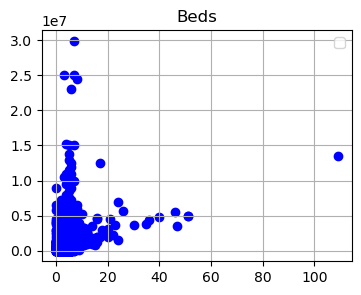

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation Coefficient is as followed:
x = 0.9999999999999999 and y = 0.3640370402041601
#################################################### END ####################################################



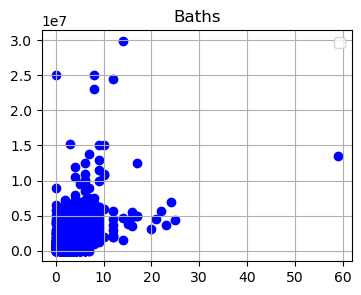

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation Coefficient is as followed:
x = 1.0 and y = 0.5134773687780688
#################################################### END ####################################################



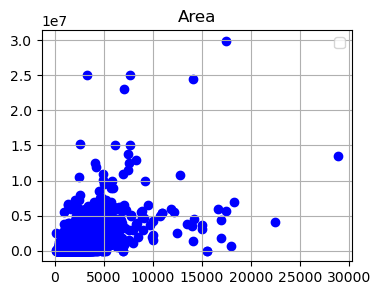

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation Coefficient is as followed:
x = 1.0 and y = 0.6056885113886524
#################################################### END ####################################################



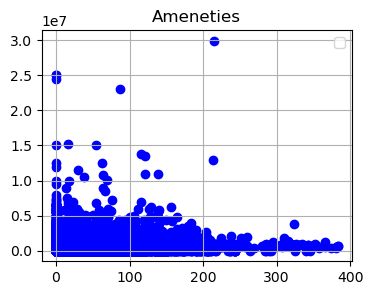

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation Coefficient is as followed:
x = 1.0 and y = -0.012671301582724386
#################################################### END ####################################################



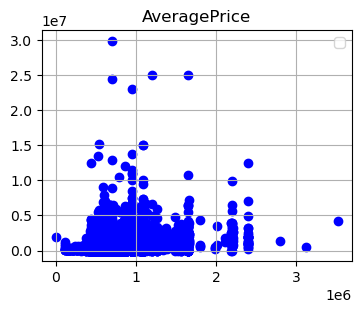

Correlation Coefficient is as followed:
x = 1.0 and y = 0.2626442636416576
#################################################### END ####################################################



In [38]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np

for label in df.columns[:-1]:
    if label != 'Price':
        try:
            warnings.simplefilter(action='ignore', category=FutureWarning)
            plt.figure(figsize=(4, 3))
            plt.title(label)
            plt.scatter(df[label], df['Price'], c ="blue")
            plt.legend()
            plt.grid(True)
            plt.show()
            #Calculating Correlation Coeffcient
            corr = np.corrcoef(df[label], df['Price'])
            print(f'Correlation Coefficient is as followed:')
            print(f'x = {corr[0][0]} and y = {corr[0][1]}')
            print('#################################################### END ####################################################\n')
        except Exception as e:
            print(e)


## What is linear regression?

Linear regression analysis is used to predict the value of a variable based on the value of another variable. The variable you want to predict is called the dependent variable. The variable you are using to predict the other variable's value is called the independent variable.

Linear regression fits a straight line or surface that minimizes the discrepancies between predicted and actual output values. There are simple linear regression calculators that use a “least squares” method to discover the best-fit line for a set of paired data.

## Analyzing The Given Data using Linear Regression

### Preparing Train, Validation and Test Datasets
> Below we will be dividing our data with different ratio for training, validation and testing respectively. The data will split using the following ratio:
> + Train: 60%
> + Validation: 20% (From 60% to 80%)
> + Testing: 20% (The left over data from 80% to 100%)

In [72]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [76]:
import copy

def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values

    Y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, Y))
    
    return data, X, Y

## Single Linear Regression

### Predicting Price with Area

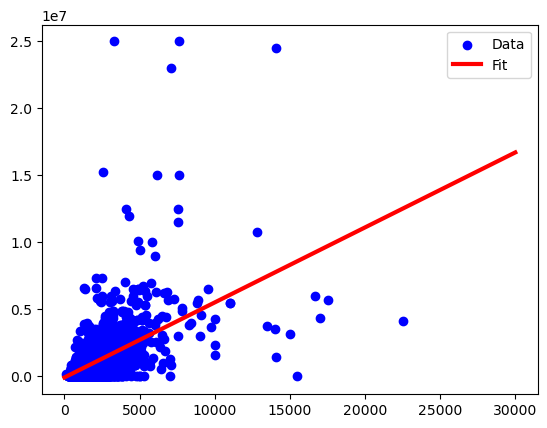

In [81]:
_, x_train_area, y_train_area = get_xy(train, "Price", x_labels=['Area'])
_, x_valid_area, y_valid_area = get_xy(valid, "Price", x_labels=['Area'])
_, x_test_area, y_test_area = get_xy(test, "Price", x_labels=['Area'])

from sklearn.linear_model import LinearRegression

area_reg = LinearRegression()
area_reg.fit(x_train_area, y_train_area)

area_reg.score(x_test_area, y_test_area)

import tensorflow as tf
plt.scatter(x_train_area, y_train_area, label="Data", color="blue")
x = tf.linspace(0, 30000, 30000)
plt.plot(x, area_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.show()

### Predicting Price with Number of Beds

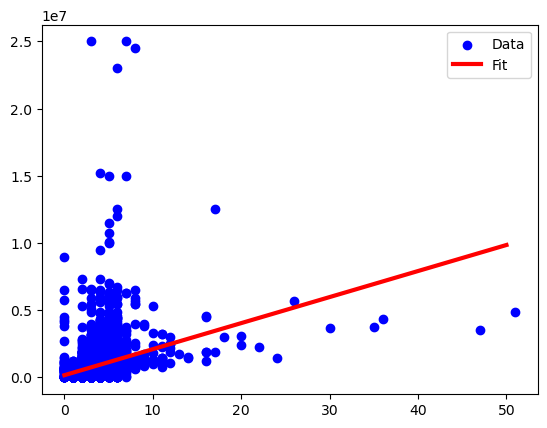

In [80]:
_, x_train_beds, y_train_beds = get_xy(train, "Price", x_labels=['Beds'])
_, x_valid_beds, y_valid_beds = get_xy(valid, "Price", x_labels=['Beds'])
_, x_test_beds, y_test_beds = get_xy(test, "Price", x_labels=['Beds'])

from sklearn.linear_model import LinearRegression

beds_reg = LinearRegression()
beds_reg.fit(x_train_beds, y_train_beds)

beds_reg.score(x_test_beds, y_test_beds)

import tensorflow as tf
plt.scatter(x_train_beds, y_train_beds, label="Data", color="blue")
x = tf.linspace(0, 50, 50)
plt.plot(x, beds_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.show()

In [ ]:
_, x_train_area, y_train_area = get_xy(train, "Price", x_labels=['Area'])
_, x_valid_area, y_valid_area = get_xy(valid, "Price", x_labels=['Area'])
_, x_test_area, y_test_area = get_xy(test, "Price", x_labels=['Area'])

from sklearn.linear_model import LinearRegression

area_reg = LinearRegression()
area_reg.fit(x_train_area, y_train_area)

area_reg.score(x_test_area, y_test_area)

import tensorflow as tf
plt.scatter(x_train_area, y_train_area, label="Data", color="blue")
x = tf.linspace(0, 30000, 30000)
plt.plot(x, area_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Area vs Price")
plt.show()

## Multiple Linear Regression

In [77]:
_, x_train_all, y_train_all = get_xy(train, "Price", x_labels=df.columns[1:])
_, x_valid_all, y_valid_all = get_xy(valid, "Price", x_labels=df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "Price", x_labels=df.columns[1:])

all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)
all_reg.score(x_test_all, y_test_all)

1.0